In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 512
lmax = 3 * nside

In [7]:
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["TT", "EE", "BB", "TE"]

change this to True   if you want to  run namaster on notebook 


In [10]:
namaster_on_nb = True

In [11]:
datadir = Path(
    "data"
)

In [12]:
imapfile = datadir / "haslam408_dsds_Remazeilles2014.fits"
qumapfile = datadir / "wmap_band_iqumap_r9_9yr_K_v5.fits"

In [13]:
if not imapfile.exists():
    !wget -O $imapfile   https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_dsds_Remazeilles2014.fits

In [14]:
if not qumapfile.exists():
    !wget -O $qumapfile   https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/raw/wmap_band_iqumap_r9_9yr_K_v5.fits

In [15]:
imap = hp.read_map(imapfile)
qumap = hp.read_map(qumapfile, field=[1, 2])


# Setting the inputs 
## Synchrotron   maps 
- We use the Haslam map at 408MHz for the intensity template 
- for Q and U we adopt maps from the K-band of WMAP .  


- rescaling Haslam map to 23 GHz **assuming a constant spectral index =-3.1**   and from K to uK 
- converting Wmap maps to from mK to uK  
- we reduce noise by smoothing to 2 deg 



In [16]:
rescaling_factor = (23.0 / 0.408) ** -3.1

imap *= rescaling_factor
imap <<= u.K_RJ
imap = imap.to(u.uK_RJ)
qumap <<= u.mK_RJ
qumap = qumap.to("uK_RJ")

In [17]:
IQU = np.array([imap, qumap[0], qumap[1]])

In [18]:
FWHM_SMOOTHING = 2  # deg
IQU = hp.smoothing(IQU, fwhm=np.radians(FWHM_SMOOTHING))
IQU <<= u.uK_RJ

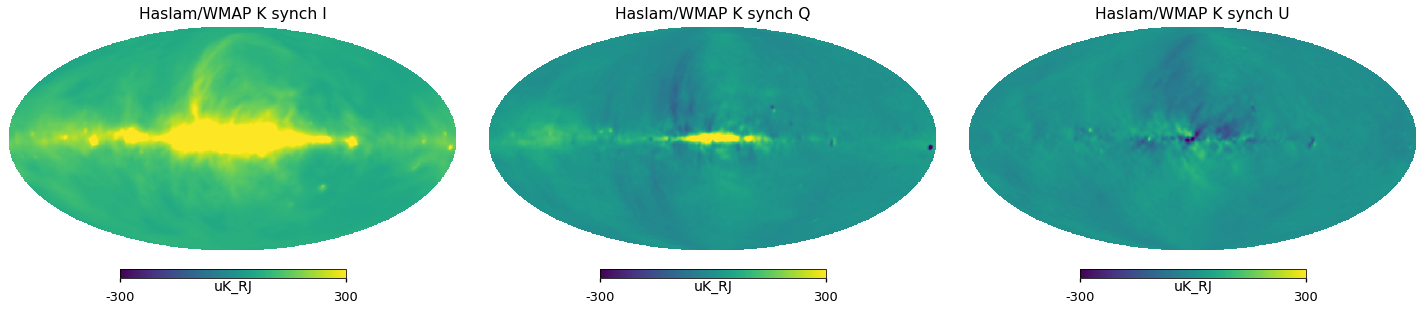

In [19]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        IQU[i_pol],
        title="Haslam/WMAP K synch " + pol,
        sub=131 + i_pol,
        unit=IQU.unit,
        min=-300,
        max=300,
    )

In [20]:
if not os.path.exists(datadir / "synch_hybrid.fits"):
    hp.write_map(datadir / "synch_hybrid.fits", IQU)

In [21]:
import numpy as np
import healpy as hp


def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P**2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

In [22]:
iqu = map_to_log_pol_tens(IQU.value)

/tmp/ipykernel_59328/931035461.py:9: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
/tmp/ipykernel_59328/931035461.py:10: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


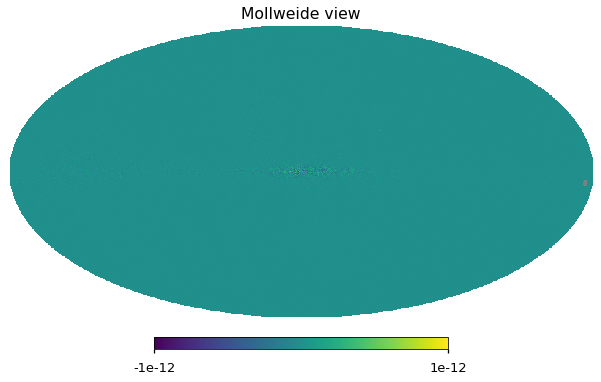

In [23]:
m_back = log_pol_tens_to_map(iqu)
hp.mollview((IQU.value - m_back)[1], min=-1e-12, max=1e-12)
del m_back

In [24]:
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)
for i in range(3):
    iqu[i, np.isnan(iqu[i])] = np.nanmedian(iqu[i])
assert np.isnan(iqu).sum() == 0
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)

527 pixels out of 3145728 are NaNs in Log Pol Tens maps 
0 pixels out of 3145728 are NaNs in Log Pol Tens maps 


In [25]:
if not os.path.exists(datadir / "synch_logpoltens.fits"):
    hp.write_map(datadir / "synch_logpoltens.fits", iqu)

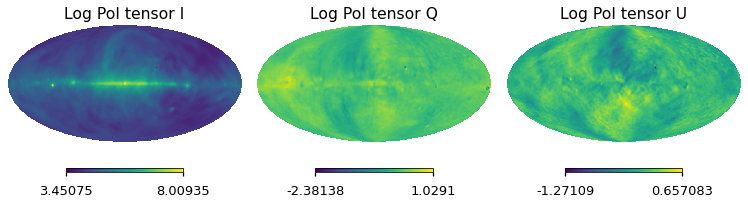

In [26]:
for i_pol, pol in components:
    hp.mollview(iqu[i_pol], title="Log Pol tensor " + pol, sub=131 + i_pol)

In [27]:
from scipy.optimize import curve_fit

In [28]:
def model(ell, A, gamma):
    out = A * ell**gamma
    return out

In [29]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1, dtype=float)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """

    nside = hp.npix2nside(len(mask))
    # b = nmt.NmtBin.from_nside_linear(nside, 16)
    # leff = b.get_effective_ells()
    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0]])
        f_2 = nmt.NmtField(
            mask, m[1:].copy(), purify_b=True
        )  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0]])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [30]:
print("run anafast on masked sky  ")
ell, cl_norm, cl = run_anafast(iqu, lmax)

run anafast on masked sky  


## Power law fit 

- We fit in$\ell \in[1-,36]$ a power law for TT spectrum of the logpol tens i map
- we use the spectral index power law also for EE and BB power spectra to avoid unphysical crossings of EE over TT and BB over TT at higher multipoles


/tmp/ipykernel_59328/3409733669.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  out = A * ell ** gamma
/tmp/ipykernel_59328/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_59328/3409733669.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma
/tmp/ipykernel_59328/3409733669.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  out = A * ell ** gamma


(1e-05, 0.1)

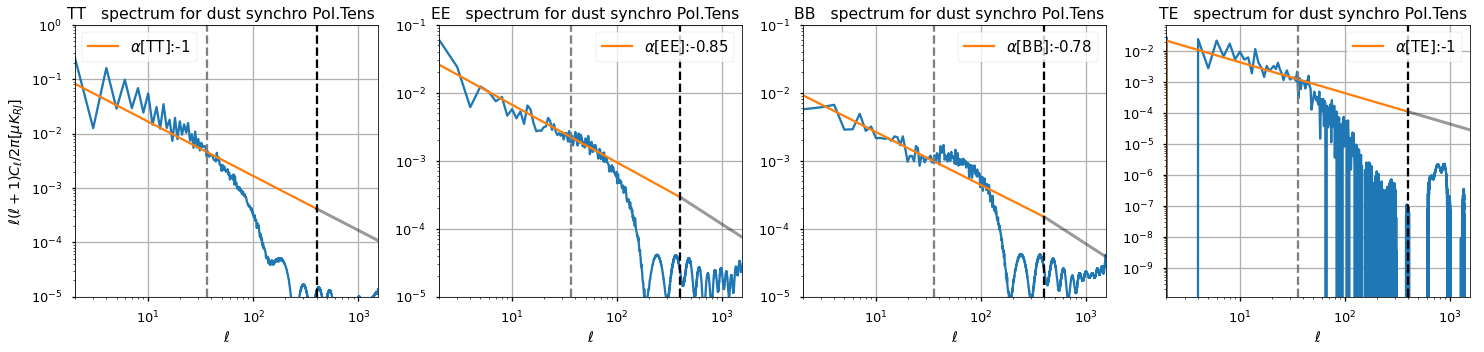

In [31]:
ell_fit_low = {"TT": 10, "EE": 10, "BB": 10, "TE": 10}
ell_fit_high = {"TT": 36, "EE": 36, "BB": 36, "TE": 36}
gamma_fit2 = {"TT": -1, "EE": -0.85, "BB": -0.78, "TE": -1}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {}, {}, {}, {}
plt.figure(figsize=(25, 5))
A_fit2 = {}
smallscales = []

ell_pivot = 400
for ii, pol in enumerate(spectra_components):
    plt.subplot(141 + ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit2[pol] = np.fabs(A_fit[pol]) * ell_fit_high[pol] ** (
        gamma_fit[pol] - gamma_fit2[pol]
    )
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol])
    scaling = model(ell[:ell_pivot], A_fit2[pol], gamma_fit2[pol])
    scaling[:2] = 0
    plt.plot(ell[:ell_pivot], scaling, label=r"$\alpha$" + f"[{pol}]:{gamma_fit2[pol]}")
    smallscales.append(scaling)

    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
    plt.axvline(ell_pivot, linestyle="--", color="k")
    plt.grid()
    plt.title(f"{pol}   spectrum for dust synchro Pol.Tens  ")

    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    plt.legend(fontsize=15)

for ii, pol in enumerate(spectra_components):
    # we change the EE and BB power laws
    xdata = np.arange(ell_fit_high[pol], ell.size)
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    plt.subplot(141 + ii)
    if pol == "TE":
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TE"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TE"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TT"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TT"])
        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

plt.subplot(141)

plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.ylim(1e-5, 1e0)
plt.subplot(142)
plt.ylim(1e-5, 1e-1)
plt.subplot(143)
plt.ylim(1e-5, 1e-1)
plt.subplot(143)
plt.ylim(1e-5, 1e-1)

### Define Modulation maps 
as suggested by Ben Thorne , 
the injected small scales are at different multipoles for intensity and polarization, we consider 2 different modulation maps  
 

#### Modulation for  intensity : 
- smooth `i` map to 5 deg 
- for  the pixels >5  MinMax rescaling from 1.1 to 2 
- elsewhere MinMax rescaling  from  .1 to 1.1   

In [32]:
ismooth = hp.smoothing(iqu[0], fwhm=np.radians(5))

In [33]:
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

modulate_amp = (ismooth) * 1.0
mskmd = ismooth > 5

modulate_amp[mskmd] = minmax(ismooth[mskmd], 1.1, 2)
modulate_amp[~mskmd] = minmax(ismooth[~mskmd], 0.1, 1.1)

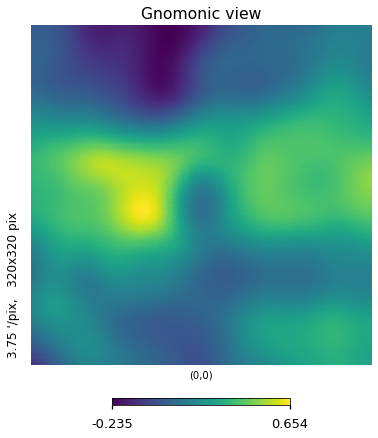

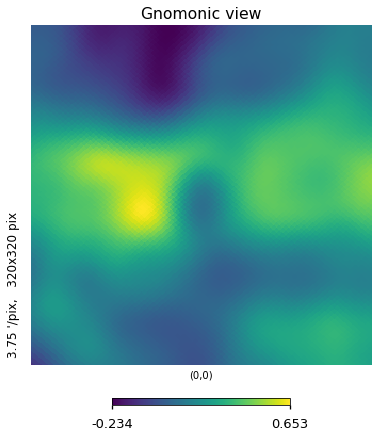

In [34]:
hp.gnomview(iqu[1], reso=3.75, xsize=320)
ulogpol = hp.ud_grade(map_in=iqu, nside_out=256)

hp.gnomview(ulogpol[1], reso=3.75, xsize=320)

In [35]:
ulogpol = hp.ud_grade(map_in=iqu, nside_out=256)
nsidepatches = 8
patches = np.arange(hp.nside2npix(nsidepatches))
nsideA = hp.get_nside(ulogpol)

upatches = hp.ud_grade(patches, nside_out=nsideA)

In [36]:
import time
import pymaster as nmt


def ClEE(mask, mapp):
    map1 = mapp.copy()
    b = nmt.NmtBin.from_nside_linear(hp.get_nside(mask), 25)
    f_2 = nmt.NmtField(mask, map1, purify_b=False)
    cl_22 = nmt.compute_full_master(f_2, f_2, b)
    ell_arr = b.get_effective_ells()
    return (ell_arr, cl_22[0])

In [37]:
small_scales_input_cl = [
    smallscales[ii] * sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol] / 10) / cl_norm
    for ii, pol in enumerate(spectra_components)
]

In [38]:
amplitude = np.zeros_like(patches, dtype=float)
for i in patches:
    start = time.perf_counter()

    maskpixs = upatches == i
    patch = maskpixs * ulogpol
    fsky = maskpixs.sum() / maskpixs.size
    ell_, clp = ClEE(maskpixs, ulogpol[1:])
    amplitude[i] = np.sqrt(abs(clp[2] / small_scales_input_cl[1][np.int_(ell_[2])]))
    end = time.perf_counter()
    if i % 100 == 0:
        print(i, end - start)

A = hp.ud_grade(amplitude, nside_out=hp.get_nside(iqu))

ampl_smooth = hp.smoothing(A, fwhm=np.radians(10), lmax=80)

ampl_smooth_minmax = minmax(ampl_smooth, a=ampl_smooth.min(), b=2)
hp.write_map(
    datadir / f"pysm2_mod_synch_nside8.fits", ampl_smooth_minmax, overwrite=True
)

0 2.162736225873232
100 2.2057910286821425
200 2.3339696247130632
300 2.3030777662061155
400 2.4646714576520026
500 2.2429573009721935
600 2.2295201290398836
700 2.3679073909297585


setting the output map dtype to [dtype('float64')]


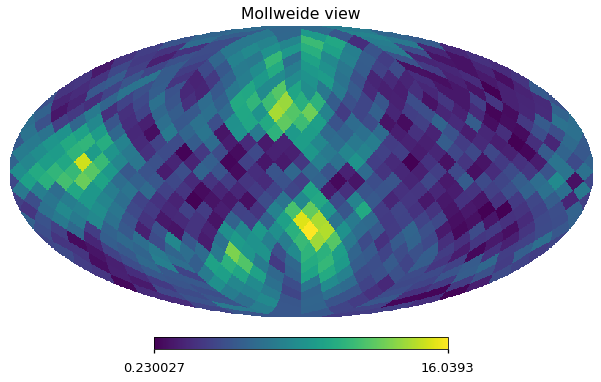

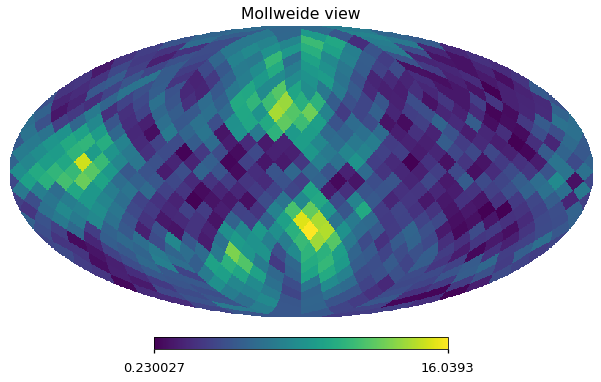

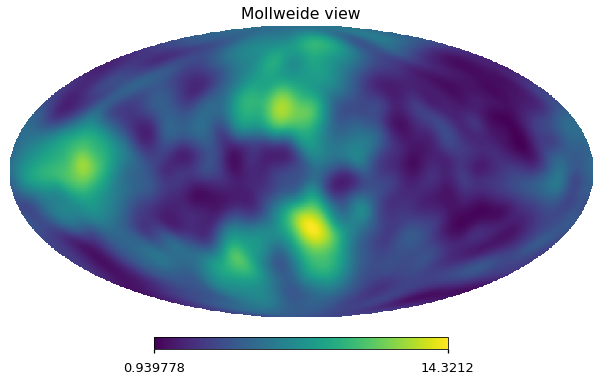

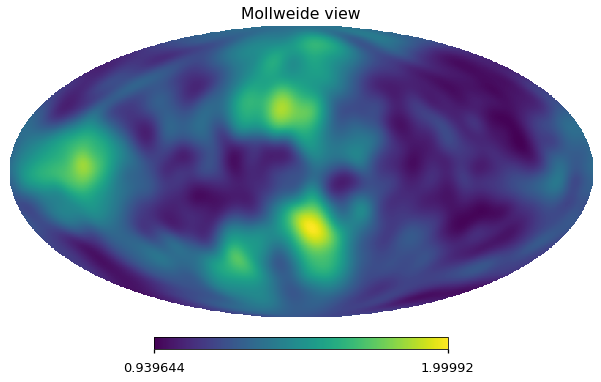

In [39]:
hp.mollview(amplitude)
hp.mollview(A)
hp.mollview(ampl_smooth)
hp.mollview(ampl_smooth_minmax)

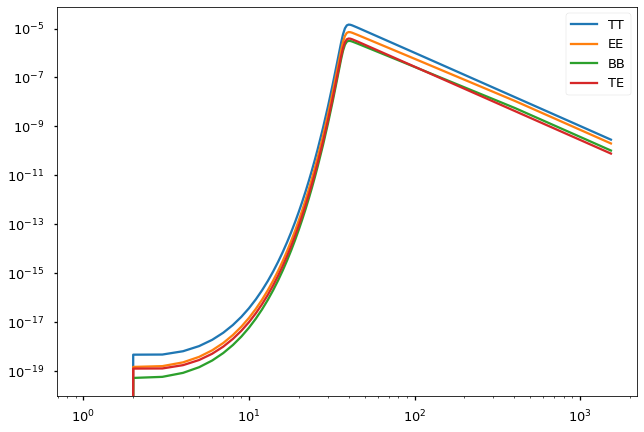

In [40]:
for i, k in enumerate(spectra_components):
    plt.loglog(small_scales_input_cl[i], label=k)
plt.legend()

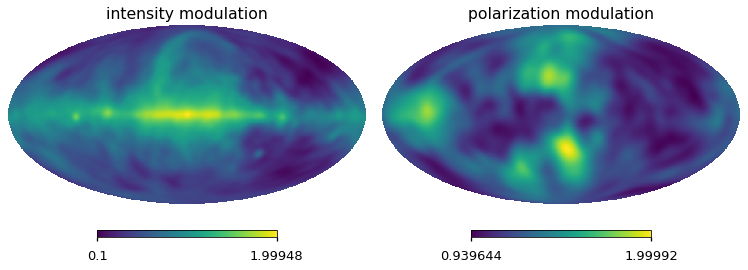

In [41]:
hp.mollview(modulate_amp, title="intensity modulation", sub=121)
hp.mollview(ampl_smooth_minmax, title="polarization modulation", sub=122)

In [42]:
np.random.seed(777)
# filter large scales
alm_log_pol_tens_fullsky = hp.map2alm(iqu, lmax=lmax, use_pixel_weights=True)
ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)

for ii, pol in enumerate(spectra_components[:-1]):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)
    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)


log_ss = hp.synfast(
    small_scales_input_cl,
    lmax=lmax,
    new=True,
    nside=hp.get_nside(iqu),
)
log_ss[0] *= modulate_amp
log_ss[1:] *= ampl_smooth_minmax

log_ls = hp.alm2map(ii_LS_alm, nside=nside)
ii_map_out = log_ss + log_ls

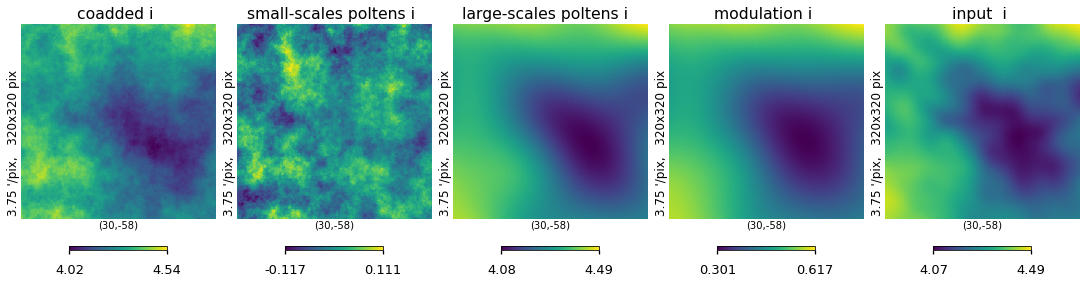

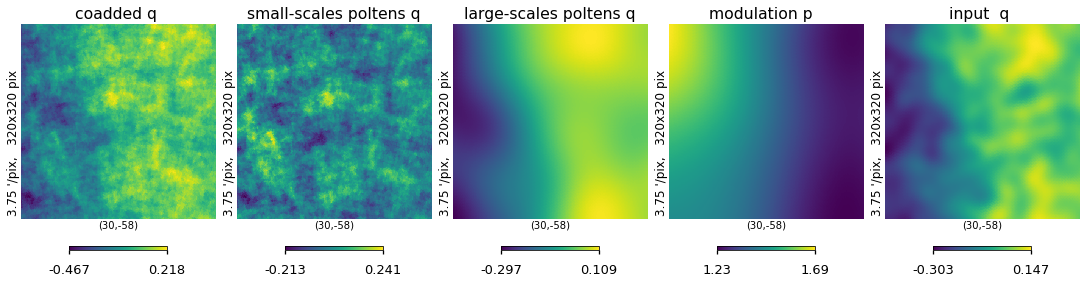

In [43]:
plt.figure(figsize=(15, 5))
hp.gnomview(
    log_ss[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=152,
    title="small-scales poltens i ",
)
hp.gnomview(
    log_ls[0],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=153,
    title="large-scales poltens i  ",
)
hp.gnomview(
    ii_map_out[0], reso=3.75, xsize=320, rot=[30, -58], sub=151, title="coadded i "
)
hp.gnomview(iqu[0], reso=3.75, xsize=320, rot=[30, -58], sub=155, title="input  i ")
hp.gnomview(
    modulate_amp, reso=3.75, xsize=320, rot=[30, -58], sub=154, title="modulation i "
)

plt.figure(figsize=(15, 5))
hp.gnomview(
    log_ss[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=152,
    title="small-scales poltens q",
)
hp.gnomview(
    log_ls[1],
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=153,
    title="large-scales poltens q",
)
hp.gnomview(
    ii_map_out[1], reso=3.75, xsize=320, rot=[30, -58], sub=151, title="coadded q "
)
hp.gnomview(iqu[1], reso=3.75, xsize=320, rot=[30, -58], sub=155, title="input  q ")
hp.gnomview(
    ampl_smooth_minmax,
    reso=3.75,
    xsize=320,
    rot=[30, -58],
    sub=154,
    title="modulation p  ",
)

In [44]:
ell, cl_norm, cltot = run_anafast(ii_map_out, lmax)

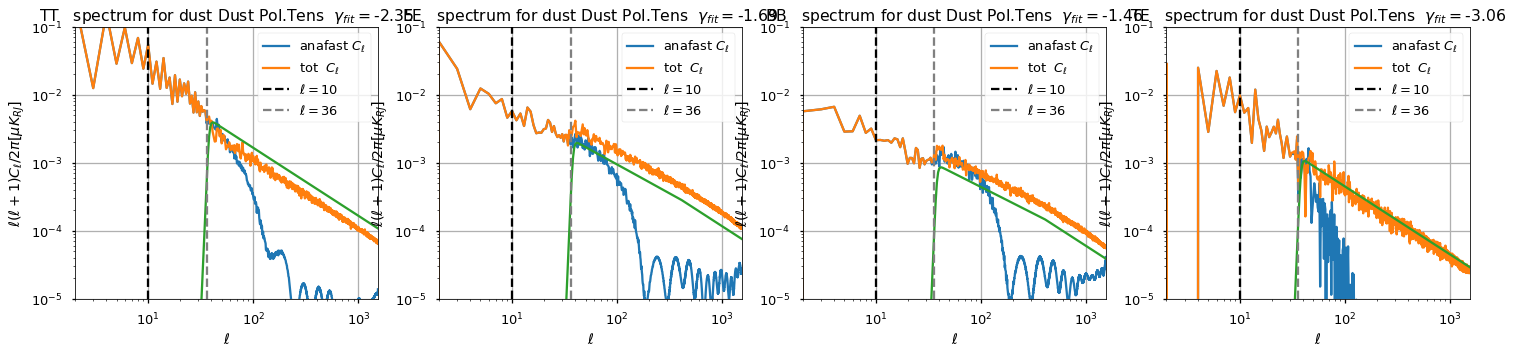

In [45]:
plt.figure(figsize=(25, 5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(141 + ii)
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol], label="anafast $C_\ell$")
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cltot[pol], label="tot  $C_\ell$")

    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * small_scales_input_cl[ii])

    plt.axvline(
        ell_fit_low[pol],
        linestyle="--",
        color="black",
        label="$ \ell={} $".format(ell_fit_low[pol]),
    )
    plt.axvline(
        ell_fit_high[pol],
        linestyle="--",
        color="gray",
        label="$ \ell={} $".format(ell_fit_high[pol]),
    )
    plt.legend()
    plt.grid()
    plt.title(
        f"{pol}   spectrum for dust Dust Pol.Tens  "
        + r"$\gamma_{fit}=$"
        + f"{gamma_fit[pol]:.2f}"
    )

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    plt.ylim(1e-5, 1e-1)

In [46]:
output_map = log_pol_tens_to_map(ii_map_out)

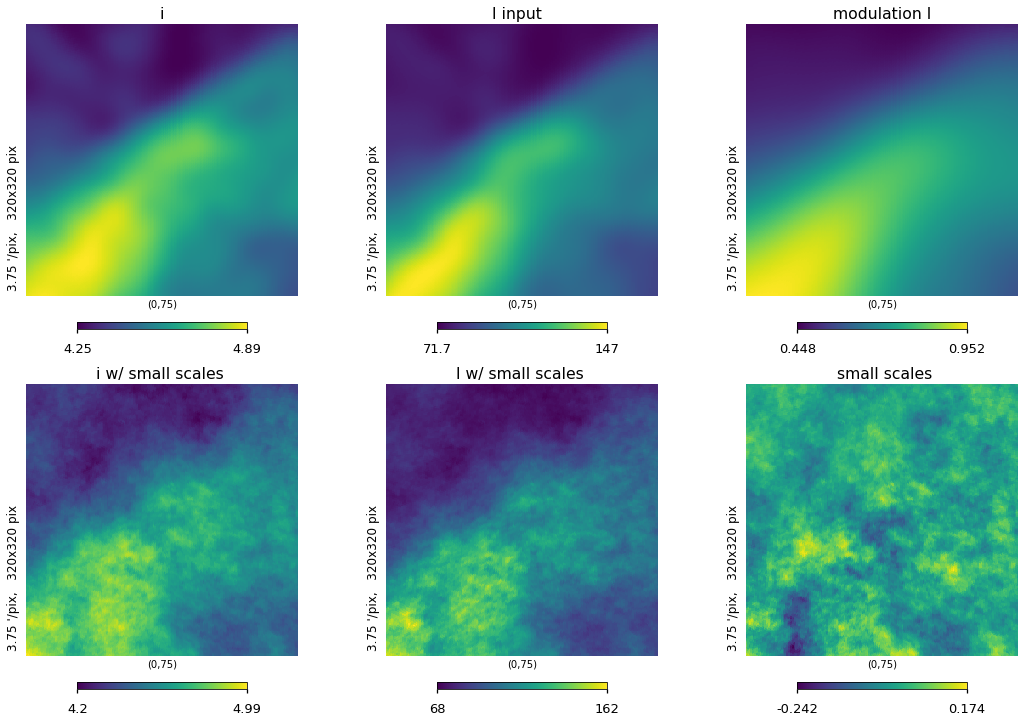

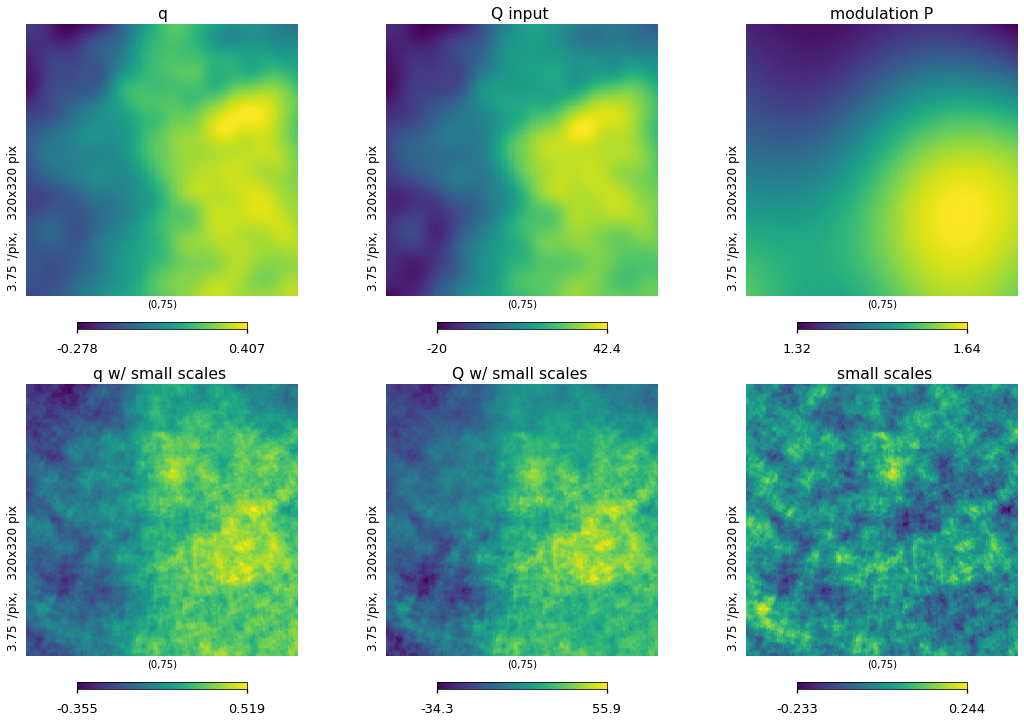

In [47]:
lat = 75
plt.figure(figsize=(15, 10))
hp.gnomview(
    ii_map_out[0],
    title="i w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=234,
)
hp.gnomview(iqu[0], title="i", rot=[0, lat], reso=3.75, xsize=320, sub=231)
hp.gnomview(
    modulate_amp,
    title=" modulation I ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=233,
)

hp.gnomview(
    (IQU[0]),
    title=" I input   ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=232,
)
hp.gnomview(
    (log_ss)[0],
    title="  small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=236,
)
hp.gnomview(
    output_map[0],
    title="I w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=235,
)
lat = 75
plt.figure(figsize=(15, 10))
hp.gnomview(
    ii_map_out[1],
    title="q w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=234,
)
hp.gnomview(iqu[1], title="q", rot=[0, lat], reso=3.75, xsize=320, sub=231)
hp.gnomview(
    (ampl_smooth_minmax),
    title=" modulation P ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=233,
)

hp.gnomview(
    (IQU[1]),
    title=" Q input  ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=232,
)
hp.gnomview(
    (log_ss)[1],
    title="  small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=236,
)
hp.gnomview(
    output_map[1],
    title="Q w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=235,
)

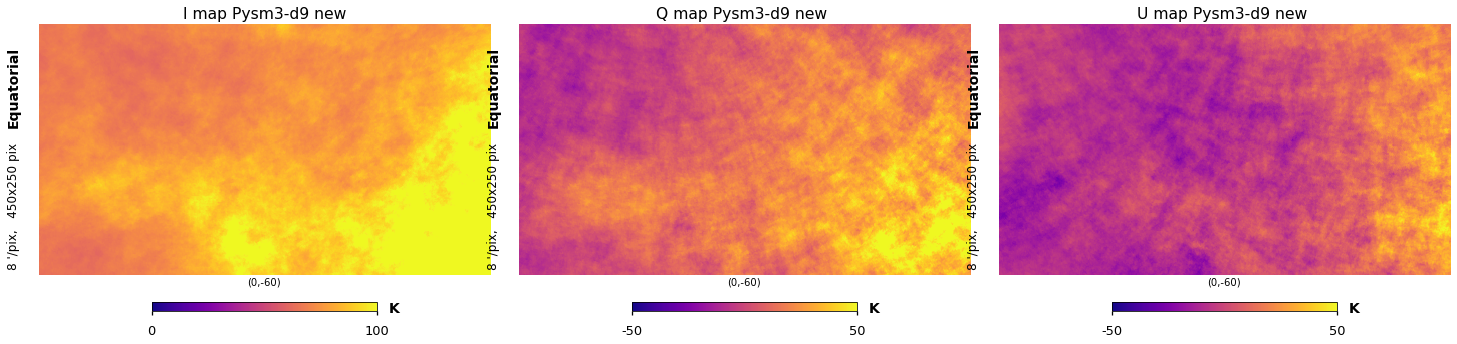

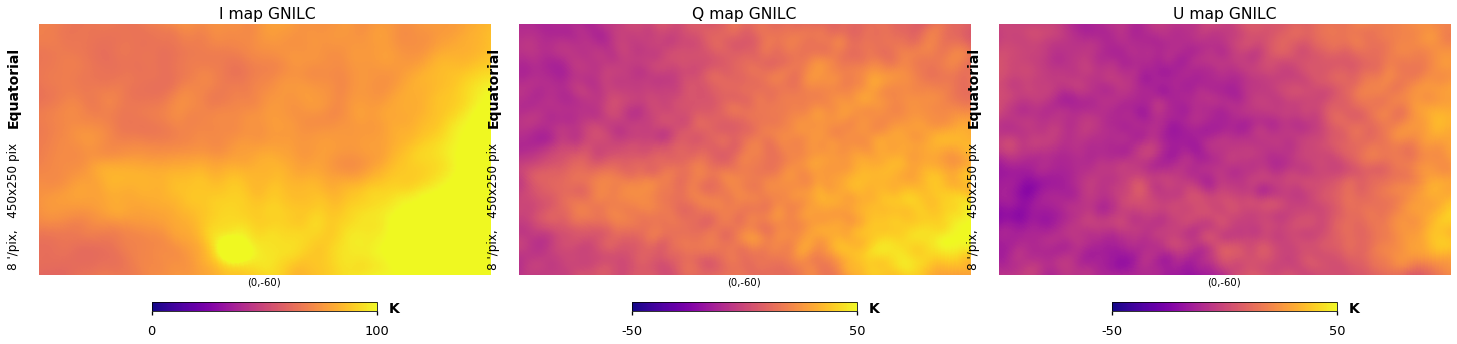

In [48]:
plt.figure(figsize=(20, 5))
hp.gnomview(
    (output_map[0]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title=" I map Pysm3-d9 new ",
    notext=False,
    sub=131,
    min=0,
    max=100,
    cmap="plasma",
)
hp.gnomview(
    (output_map[1]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="Q map Pysm3-d9 new ",
    notext=False,
    sub=132,
    min=-50,
    max=50,
    cmap="plasma",
)
hp.gnomview(
    (output_map[2]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="U map Pysm3-d9 new ",
    notext=False,
    sub=133,
    min=-50,
    max=50,
    cmap="plasma",
)


plt.figure(figsize=(20, 5))
hp.gnomview(
    (IQU[0]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title=" I map GNILC",
    notext=False,
    sub=131,
    min=0,
    max=100,
    cmap="plasma",
)
hp.gnomview(
    (IQU[1]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="Q map GNILC",
    notext=False,
    sub=132,
    min=-50,
    max=50,
    cmap="plasma",
)
hp.gnomview(
    (IQU[2]),
    reso=8,
    xsize=450,
    ysize=250,
    coord=["G", "C"],
    rot=[0, -60],
    cbar=True,
    unit="K",
    title="U map GNILC",
    notext=False,
    sub=133,
    min=-50,
    max=50,
    cmap="plasma",
)

In [49]:
if not os.path.exists(datadir / "sync_pysm_mod_out.fits"):
    hp.write_map(datadir / "sync_pysm_mod_out.fits", output_map, overwrite=True)

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


### Validation 


In [50]:
bkmaskfile = datadir / "bk14_mask_gal_n0512.fits"
if not bkmaskfile.exists():
    !wget -O $bkmaskfile http://bicepkeck.org/BK14_datarelease/bk14_mask_gal_n0512.fits
maskbk = hp.read_map(bkmaskfile, verbose=False)
idx = np.where((maskbk < 0) | (~np.isfinite(maskbk)))
maskbk[idx] = 0

In [51]:
aoa = "/global/cscratch1/sd/flauger/S4_misc/weights_aoa_spsat_apo_gal_512.fits"
mask_aoa = hp.read_map(aoa, verbose=False)

In [52]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

if not planck_mask_filename.exists():
    !wget -O $planck_mask_filename "http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

In [53]:
planck_masks = {
    "GAL099": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL099"]), nside_out=512),
    "GAL097": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL097"]), nside_out=512),
    "GAL090": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL090"]), nside_out=512),
    "GAL080": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL080"]), nside_out=512),
    "GAL070": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL070"]), nside_out=512),
    "GAL060": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL060"]), nside_out=512),
    "GAL040": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL040"]), nside_out=512),
    "GAL020": hp.ud_grade(hp.read_map(planck_mask_filename, ["GAL020"]), nside_out=512),
}

In [54]:
ell, cl_norm, clo = run_anafast(output_map, lmax=2048)
ell, cl_norm, cli = run_anafast(IQU, lmax=2048)

In [55]:
colors = plt.cm.cividis(np.linspace(0, 1, len(planck_masks.keys()) + 1))

GAL099
GAL097
GAL090
GAL080
GAL070
GAL060
GAL040
GAL020


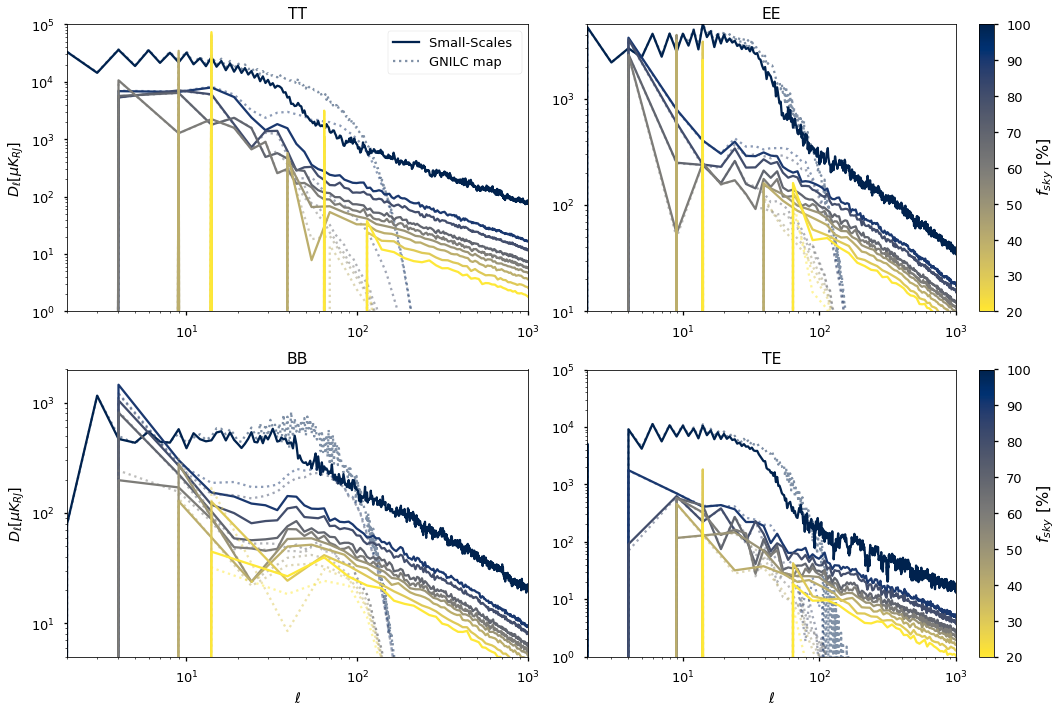

In [89]:
bins = {
    "GAL099": 5,
    "GAL097": 5,
    "GAL090": 5,
    "GAL080": 5,
    "GAL070": 15,
    "GAL060": 15,
    "GAL040": 25,
    "GAL020": 25,
}
plt.figure(figsize=(15, 10))
import os

# for jj, k in enumerate([ "GAL080","GAL070","GAL040" ])  :
for jj, k in enumerate(planck_masks.keys()):
    print(k)
    fspectra = datadir / f"sync_input_gal{k[3:]}_spectra.npz"
    if os.path.exists(fspectra):
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:
        input_ell, cl_norm, cl_in = run_namaster(
            m=IQU, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=input_ell,
            TT=cl_in["TT"],
            EE=cl_in["EE"],
            BB=cl_in["BB"],
            TE=cl_in["TE"],
        )
    fspectra = datadir / f"sync_pysmmod_nside8_planck_gal{k[3:]}_spectra.npz"

    if os.path.exists(fspectra):
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}
    else:

        output_ell, cl_norm, cl_out = run_namaster(
            m=output_map, mask=planck_masks[k], lmax=1300, nlbins=bins[k]
        )
        np.savez(
            fspectra,
            ell=output_ell,
            TT=cl_out["TT"],
            EE=cl_out["EE"],
            BB=cl_out["BB"],
            TE=cl_out["TE"],
        )

    for ii, pol in enumerate(["TT", "EE", "BB", "TE"]):
        plt.subplot(2, 2, ii + 1)
        if jj == 0:
            plt.title(pol)
            plt.loglog(
                ell,
                ell**2 * (clo[pol]),
                label="Small-Scales ",
                color=colors[0],
            )
            plt.loglog(
                ell,
                ell**2 * (cli[pol]),
                ":",
                label="GNILC map ",
                color=colors[0],
                alpha=0.5,
            )
        plt.loglog(output_ell, output_ell**2 * (cl_out[pol]), color=colors[jj + 1])
        # ,label =f"{k}")
        plt.loglog(
            input_ell,
            input_ell**2 * (cl_in[pol]),
            ":",
            color=colors[jj + 1],
            alpha=0.5,
        )

plt.subplot(221)
plt.legend()
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
plt.ylim(1e0, 1e5)
plt.xlim(2, 1e3)

plt.subplot(222)
plt.ylim(1e1, 5e3)
plt.xlim(2, 1e3)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation="90", fontsize=16)
plt.subplot(223)
plt.ylabel("$ D_\ell  [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))

plt.ylim(5e0, 2e3)
plt.xlim(2, 1e3)

plt.subplot(224)
plt.ylim(1e0, 1e5)
plt.xlim(2, 1e3)

plt.xlabel(("$\ell$"))
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r"$f_{sky}$ [%]", rotation="90", fontsize=16)
plt.tight_layout()

/tmp/ipykernel_59328/3012373139.py:13: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( ell,  (clo ["EE"]/ clo["BB"] ),   color=colors[0] ,alpha=1)
/tmp/ipykernel_59328/3012373139.py:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( output_ell,  (cl_out ["EE"]/ cl_out["BB"] ),  color=colors[jj+1] ,alpha=1)
/tmp/ipykernel_59328/3012373139.py:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( output_ell,  (cl_out ["EE"]/ cl_out["BB"] ),  color=colors[jj+1] ,alpha=1)
/tmp/ipykernel_59328/3012373139.py:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( output_ell,  (cl_out ["EE"]/ cl_out["BB"] ),  color=colors[jj+1] ,alpha=1)
/tmp/ipykernel_59328/3012373139.py:14: RuntimeWarning: invalid value encountered in true_divide
  plt.plot( output_ell,  (cl_out ["EE"]/ cl_out["BB"] ),  color=colors[jj+1] ,alpha=1)
/tmp/ipykernel_59328/3012373139.py:14: RuntimeWarning: invalid value encountered in true_divide
  pl

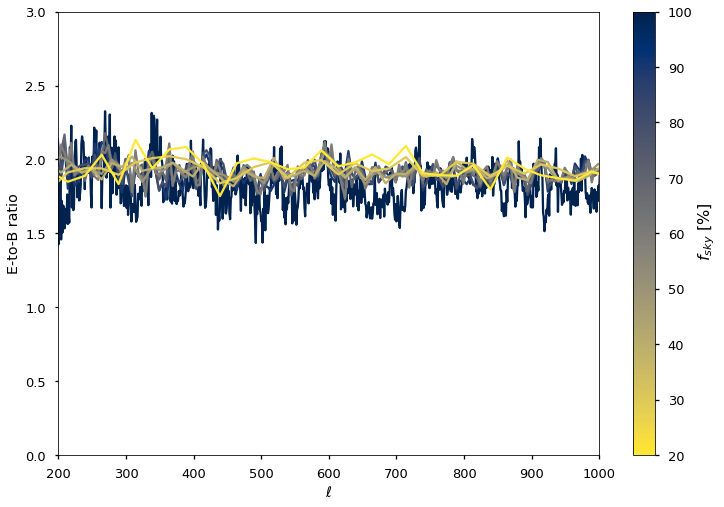

In [75]:
# plt.figure(figsize=(15,10 ))
import os

for jj, k in enumerate(planck_masks.keys()):

    fspectra = datadir / f"sync_pysmmod_nside8_planck_gal{k[3:]}_spectra.npz"
    if os.path.exists(fspectra):
        #        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components + ["TE"]}

    if jj == 0:
        plt.plot(ell, (clo["EE"] / clo["BB"]), color=colors[0], alpha=1)
    plt.plot(output_ell, (cl_out["EE"] / cl_out["BB"]), color=colors[jj + 1], alpha=1)

plt.xlim(200, 1e3)
plt.ylim(0, 3)
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.cividis_r, norm=plt.Normalize(vmin=20.0, vmax=100)
)
cb = plt.colorbar(sm)
cb.set_label(r" $f_{sky}$ [%]", rotation="90", fontsize=16)
plt.xlabel(("$\ell$"))
plt.ylabel(("E-to-B ratio"))

plt.tight_layout()

In [76]:
def ClBB(mask, mapp):
    map1 = mapp.copy()
    b = nmt.NmtBin.from_nside_linear(hp.get_nside(mask), 40)
    f_2 = nmt.NmtField(mask, map1, purify_b=True)
    cl_22 = nmt.compute_full_master(f_2, f_2, b)
    ell_arr = b.get_effective_ells()
    return (ell_arr, cl_22[3], cl_22[0])

In [77]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

In [60]:
i_dic = {}
(ells, clBB_i, clEE_i) = ClBB(mask_aoa, IQU[1:, :])

i_dic["proposed_S4"] = [clBB_i, clEE_i]
(ells, clBB_i, clEE_i) = ClBB(maskbk, IQU[1:, :])
i_dic["southern_hole"] = [clBB_i, clEE_i]

In [78]:
o_dic = {}

(oells, clBB_o, clEE_o) = ClBB(mask_aoa, output_map[1:, :])
o_dic["proposed_S4"] = [clBB_o, clEE_o]
(oells, clBB_o, clEE_o) = ClBB(maskbk, output_map[1:, :])
o_dic["southern_hole"] = [clBB_o, clEE_o]

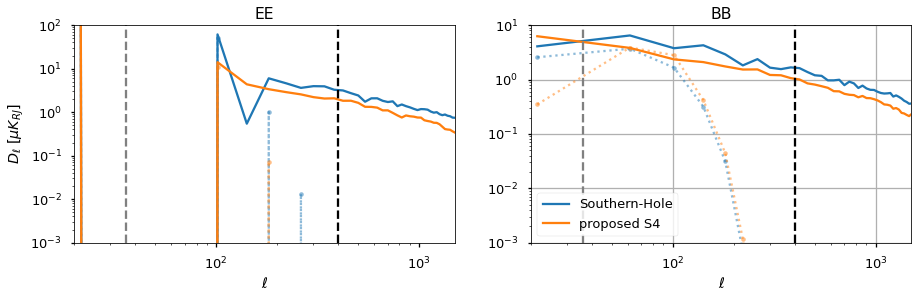

In [80]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.title("EE")
plt.ylabel("$ D_\ell\,\,  [\mu K_{RJ}]$")
plt.xlabel(("$\ell$"))

plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["southern_hole"][1] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C0",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["southern_hole"][1] / (2.0 * np.pi),
    label="BK",
    color="C0",
)
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["proposed_S4"][1] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C1",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["proposed_S4"][1] / (2.0 * np.pi),
    label="Southern-Hole",
    color="C1",
)
plt.loglog()
plt.ylim(1e-3, 1e2)
plt.xlim(20, 1.5e3)
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
plt.axvline(ell_pivot, linestyle="--", color="k")
plt.subplot(122)
plt.title("BB")
plt.xlabel(("$\ell$"))
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["southern_hole"][0] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C0",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["southern_hole"][0] / (2.0 * np.pi),
    label="Southern-Hole",
    color="C0",
)
plt.plot(
    ells,
    ells * (ells + 1.0) * i_dic["proposed_S4"][0] / (2.0 * np.pi),
    ".",
    alpha=0.5,
    color="C1",
    linestyle=":",
)
plt.plot(
    oells,
    oells * (oells + 1.0) * o_dic["proposed_S4"][0] / (2.0 * np.pi),
    label="proposed S4",
    color="C1",
)
plt.loglog()
plt.ylim(1e-3, 1e1)
plt.xlim(20, 1.5e3)
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
plt.axvline(ell_pivot, linestyle="--", color="k")
plt.legend()
plt.grid()

In [81]:
get_polfrac = lambda m: np.sqrt(m[1] ** 2 + m[2] ** 2) / m[0]

In [82]:
Pout = get_polfrac(output_map)
Pin = get_polfrac(IQU.value)
logpin = np.log10(Pin)
logpout = np.log10(Pout)

In [83]:
planck_masks_bool = {
    k: np.ma.masked_greater(m, 0).mask for k, m in planck_masks.items()
}

GAL099
GAL097
GAL090
GAL080
GAL070
GAL060
GAL040
GAL020


(-2.0, 0.0)

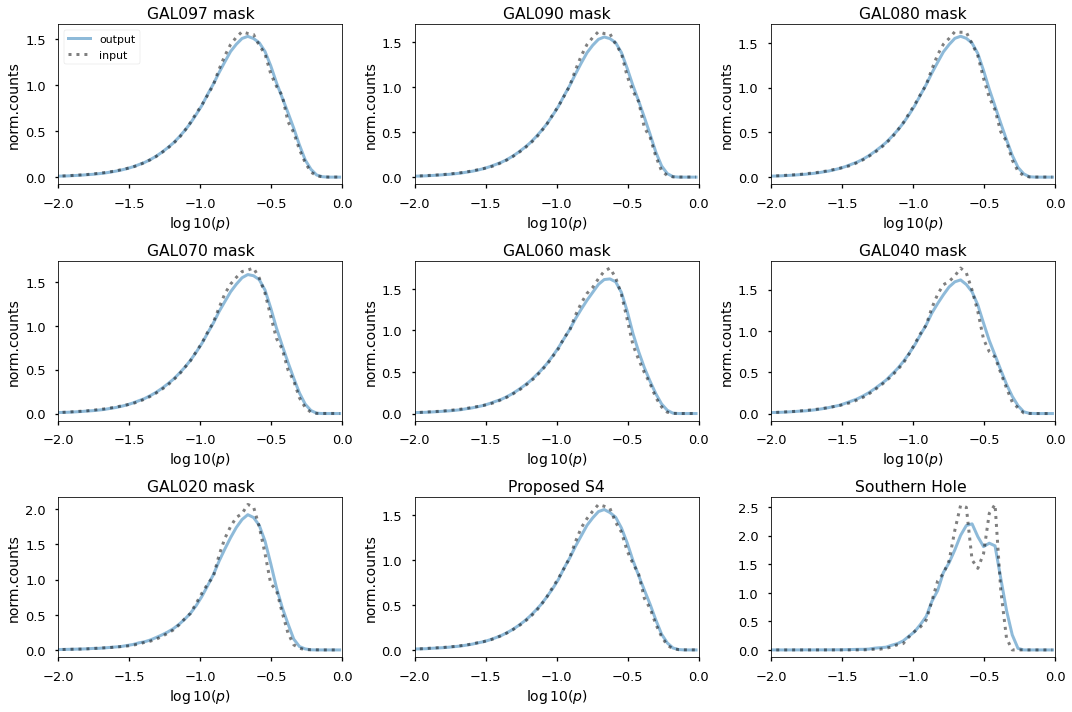

In [88]:
plt.figure(figsize=(15, 10))

for jj, pm in enumerate(planck_masks_bool.items()):
    k = pm[0]
    msk = pm[1]
    print(k)
    if k == "GAL099":
        continue
    plt.subplot(3, 3, jj)

    h, edg = np.histogram(logpout[msk], bins=np.linspace(-4, 0, 100), density=True)
    xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

    plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
    h, edg = np.histogram(logpin[msk], density=True, bins=np.linspace(-4, 0, 100))
    xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])

    plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
    plt.ylabel("norm.counts", fontsize=14)
    plt.xlabel(r"$\log10( p )$", fontsize=14)
    plt.title(k + " mask")
    plt.xlim(-2, -0)

plt.tight_layout()
plt.subplot(331)
plt.legend(fontsize=11, loc="upper left")

plt.subplot(339)


h, edg = np.histogram(
    logpout[np.ma.masked_greater(maskbk, 0).mask],
    bins=np.linspace(-4, 0, 100),
    density=True,
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
h, edg = np.histogram(
    logpin[np.ma.masked_greater(maskbk, 0).mask],
    density=True,
    bins=np.linspace(-4, 0, 100),
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
plt.title("Southern Hole ")
plt.xlim(-2, -0)

plt.subplot(338)


h, edg = np.histogram(
    logpout[np.ma.masked_greater(mask_aoa, 0).mask],
    bins=np.linspace(-4, 0, 100),
    density=True,
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, color="C0", alpha=0.5, label="output")
h, edg = np.histogram(
    logpin[np.ma.masked_greater(mask_aoa, 0).mask],
    density=True,
    bins=np.linspace(-4, 0, 100),
)
xb = np.array([(edg[i] + edg[i + 1]) / 2 for i in range(edg.size - 1)])
plt.plot(xb, h, lw=3, alpha=0.5, color="k", linestyle=":", label="input")
plt.ylabel("norm.counts", fontsize=14)
plt.xlabel(r"$\log10( p )$", fontsize=14)
plt.title("Proposed S4")
plt.xlim(-2, -0)